# Annotationen_Evaluation_V2 [![DOI](https://zenodo.org/badge/660157642.svg)](https://zenodo.org/badge/latestdoi/660157642)
![Notes on (Computational) Social Media Research Banner](https://raw.githubusercontent.com/michaelachmann/social-media-lab/main/images/banner.png)

## Overview

This Jupyter notebook is a part of the social-media-lab.net project, which is a work-in-progress textbook on computational social media analysis. The notebook is intended for use in my classes.

The **GPT Evaluation V2** Notebook helps to calculate interrater agreement scores like Cohen's Kappa and Krippendorff's Alpha for a combination of human annotations (exported from [Label Studio](https://labelstud.io/) and GPT- (or other ML/LLM) based annotations. Version two handles multiple JSON files as input, compatible with the open source version of LabelStudio.

### Project Information

- Project Website: [social-media-lab.net](https://social-media-lab.net/)
- GitHub Repository: [https://github.com/michaelachmann/social-media-lab](https://github.com/michaelachmann/social-media-lab)

## License Information

This notebook, along with all other notebooks in the project, is licensed under the following terms:

- License: [GNU General Public License version 3.0 (GPL-3.0)](https://www.gnu.org/licenses/gpl-3.0.de.html)
- License File: [LICENSE.md](https://github.com/michaelachmann/social-media-lab/blob/main/LICENSE.md)


## Citation

If you use or reference this notebook in your work, please cite it appropriately. Here is an example of the citation:

```
Michael Achmann. (2024). michaelachmann/social-media-lab: 2024-01-29 (v0.0.11). Zenodo. https://doi.org/10.5281/zenodo.8199902
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# @title Read the LabelStudio Annotations from file
# @markdown <p><b>NEW</b> This version deals with multiple annotation projects. The community version of Label Studio does not handle more than one annotator per item. Setup three different projects using the same data and have one annotator use one project. Export the results and add the files to the list below. The python loop creates one annotation dataset from the three annotations projects and provides all interrater reliability measures as with previous versions of this notebook.<p>
# @markdown <p><b>NEW</b> This version handles `labels` for the annotation of bounding boxes in images.</p>
# @markdown <p><b>NOTE</b> This version does not handle reviews!</p>

human_annotations_jsons = ['/content/drive/MyDrive/Klimawandel Projekt/Annotation_Vergleich_Labelstudio_GPT/Klimawandel1 JSON.json',
                           '/content/drive/MyDrive/Klimawandel Projekt/Annotation_Vergleich_Labelstudio_GPT/Klimawandel2 JSON.json',
                           '/content/drive/MyDrive/Klimawandel Projekt/Annotation_Vergleich_Labelstudio_GPT/Klimawandel3 JSON.json']

import json
import pandas as pd
from tqdm.notebook import tqdm

exported_annotations = []

for human_annotations_json in human_annotations_jsons:
  with open(human_annotations_json, 'r') as f:
    j = f.read()
    exported_annotations.append(json.loads(j))



def process_result(result, coder, md):
    value_type = result.get('type', "")
    metadata = {
        **md,
        "coder": coder,
        "from_name": result.get('from_name', "")
    }
    annotations = []
    if value_type == "choices":
        choices = result['value'].get('choices', [])
        for choice in choices:
            r = {**metadata}
            r['value'] = choice
            annotations.append(r)
    elif value_type == "taxonomy":
        taxonomies = result['value'].get('taxonomy', [])
        for taxonomy in taxonomies:
            if len(taxonomy) > 1:
                taxonomy = " > ".join(taxonomy)
            elif len(taxonomy) == 1:
                taxonomy = taxonomy[0]
            r = {**metadata}
            r['value'] = taxonomy
            annotations.append(r)
    elif value_type == "labels":
        labels = result['value'].get('labels', [])
        labels_id = result.get('id', '')
        label = "".join(labels)
        r = {**metadata}
        r['value'] = label
        r['id'] = labels_id
        annotations.append(r)

    return annotations

all_annotations = []
for exported_annotation in tqdm(exported_annotations):
  for data in tqdm(exported_annotation):
      annotations = data.get("annotations")
      metadata = {
          **data.get("data")
      }

      for annotation in annotations:
        coder = annotation['completed_by']
        results = annotation.get("result")
        if results:
          for result in results:
            all_annotations.extend(process_result(result, coder, metadata))
        else:
          print("Skipped Missing Result")


all_annotations_df = pd.DataFrame(all_annotations)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Skipped Missing Result


  0%|          | 0/1200 [00:00<?, ?it/s]

Skipped Missing Result


  0%|          | 0/1200 [00:00<?, ?it/s]

In [3]:
# Check the dataframe
all_annotations_df

,image,coder,from_name,value
0,gs://social_media_analysis_climate_change/6631...,25,choice1,Yes
1,gs://social_media_analysis_climate_change/6631...,25,choice2,Photo
2,gs://social_media_analysis_climate_change/6631...,25,choice3,Negative
3,gs://social_media_analysis_climate_change/6631...,25,choice4,Yes
4,gs://social_media_analysis_climate_change/6631...,25,choice5,No
...,...,...,...,...
35308,gs://social_media_analysis_climate_change/save...,29,choice5,No
35309,gs://social_media_analysis_climate_change/save...,29,choice6,No
35310,gs://social_media_analysis_climate_change/save...,29,choice7,No
35311,gs://social_media_analysis_climate_change/save...,29,choice8,Yes


In [4]:
all_annotations_df['id'] = all_annotations_df['image'].str.replace('.jpeg','.jpg').str[42:]

<ipython-input-4-90218459a2d9>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  all_annotations_df['id'] = all_annotations_df['image'].str.replace('.jpeg','.jpg').str[42:]


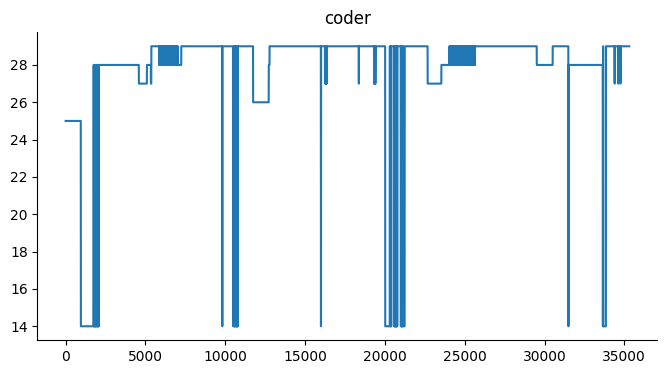

In [ ]:
# @title coder

from matplotlib import pyplot as plt
all_annotations_df['coder'].plot(kind='line', figsize=(8, 4), title='coder')
plt.gca().spines[['top', 'right']].set_visible(False)

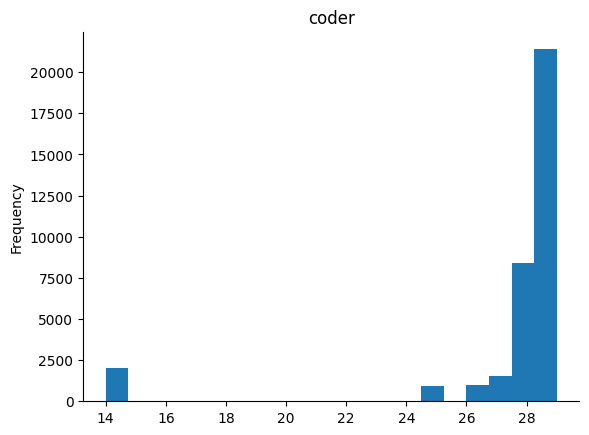

In [5]:
# @title coder

from matplotlib import pyplot as plt
all_annotations_df['coder'].plot(kind='hist', bins=20, title='coder')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Contingency Table

We select one coding in this step (e.g. Positioning) and create a contingency table where each annotated item (text, image) occupies one row and each coder one column. The `identifier` should be set to a unique column, like `uuid` or `Filename`.

In [6]:
# @markdown  Enter the `from_name` for the variable you're interested in at the moment. (Refer to your LabelStudio Interface for the right `from_name`).

import pandas as pd
import numpy as np

from_name = 'choice6' # @param {type:"string"}
identifier = 'id' # @param {type:"string"}

# Assuming your DataFrame is named 'df'
filtered_df = all_annotations_df[all_annotations_df['from_name'].str.contains(from_name, case=False)]

def to_bool(val):
  if isinstance(val, bool):
    return val
  if isinstance(val, str):
    return val.lower() == "true"

  return bool(val)

values = filtered_df['value'].unique()
identifier_values = filtered_df[identifier].unique()

contingency_matrix = pd.crosstab(filtered_df[identifier], filtered_df['coder'], values=filtered_df['value'], aggfunc='first')
contingency_matrix = contingency_matrix.reindex(identifier_values)

In [7]:
# Let's take a look at the contigency table. We refer to each coder using a pseudonymous number.
contingency_matrix.head()

coder,14,25,26,27,28,29
id,,,,,,
6631715750958599429.jpg,NaN,No,No,NaN,No,NaN
6675052941205835014.jpg,NaN,No,No,NaN,No,NaN
6684627511248162053.jpg,NaN,No,No,NaN,No,NaN
6693362974565862662.jpg,NaN,Yes,Yes,NaN,Yes,NaN
6696476394282552581.jpg,NaN,Yes,Yes,NaN,Yes,NaN


### Calculate Pairwise $\kappa$

Let's calculate Cohen's Kappa for each coder pair.

In [8]:
from sklearn.metrics import cohen_kappa_score

# Function to calculate Cohen's Kappa for each pair of raters
def calculate_kappa(matrix):
    raters = matrix.columns
    kappa_scores = []
    for i in range(len(raters)):
        for j in range(i+1, len(raters)):
            rater1, rater2 = raters[i], raters[j]
            # Drop NA values for the pair of raters
            pair_matrix = matrix[[rater1, rater2]].dropna()
            # Skip pairs without overlaps
            if len(pair_matrix) > 0:
              kappa = cohen_kappa_score(pair_matrix[rater1], pair_matrix[rater2])
              kappa_scores.append({
                  "Coder 1": rater1,
                  "Coder 2": rater2,
                  "Kappa": kappa,
                  "Overlap": len(pair_matrix),
                  "Coding": from_name
                  })
    return kappa_scores

kappa_scores = calculate_kappa(contingency_matrix)
kappa_scores_df = pd.DataFrame(kappa_scores)

In [9]:
# Let's display the pairwise Kappa agreements.
kappa_scores_df

,Coder 1,Coder 2,Kappa,Overlap,Coding
0,14,26,1.000000,3,choice6
1,14,28,0.952563,132,choice6
2,14,29,0.918687,197,choice6
3,25,26,0.834171,99,choice6
4,25,28,0.927273,76,choice6
5,25,29,0.739623,23,choice6
6,26,28,0.898305,80,choice6
7,26,29,0.913208,23,choice6
8,27,28,1.000000,7,choice6
9,27,29,0.911065,157,choice6


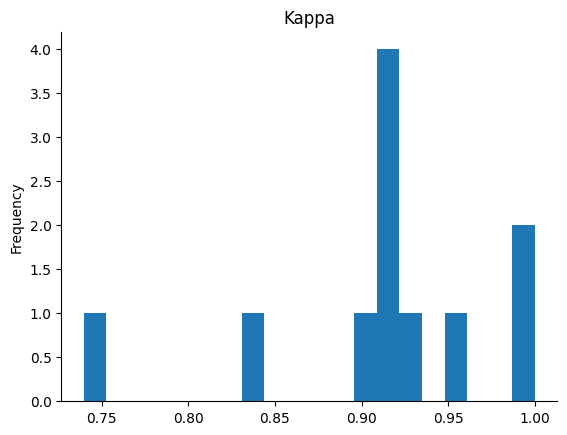

In [10]:
# @title Kappa

from matplotlib import pyplot as plt
kappa_scores_df['Kappa'].plot(kind='hist', bins=20, title='Kappa')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Overall Agreement: Krippendorff's $\alpha$

Next, we calculate the overall agreement using Krippendorffs Alpha. First we need to install the package.

In [11]:
!pip install krippendorff

In [12]:
import krippendorff
import pandas as pd

def convert_to_reliability_data(matrix):
    transposed_matrix = matrix.T
    reliability_data = []
    for _, ratings in transposed_matrix.iterrows():
        reliability_data.append(ratings.tolist())
    return reliability_data

reliability_data = convert_to_reliability_data(contingency_matrix)

# Calculating Krippendorff's Alpha treating "Unsure" as a distinct category
alpha = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement='nominal')

print("Krippendorff's Alpha:", alpha)

Krippendorff's Alpha: 0.9201542885672788


## Majority Decision

One approach to assess the quality of machine labelled data is the comparison between machine-generated labels and human-generated labels, commonly known as "gold standard" labels. This process is called "label agreement" or "inter-rater agreement" and is widely used in various fields, including natural language processing, machine learning, and computational social science.

We are going to use create a `majority_decision` column using the human annotations: We have chosen an uneven number of annotators in order to find a majority for each label. First, we are going to create a contingency table (or matrix), then we can determine the majority decision.

In [13]:
import numpy as np
import pandas as pd

# Each row represents an item, and each column a decision from a different annotator.

# Step 1: Find the mode (most common decision) for each row
# The mode is used as it represents the majority decision.
# decisions will have the most frequent value in each row, handling ties by keeping all modes.
decisions = contingency_matrix.mode(axis=1)

# Step 2: Extract the primary mode (first column after mode operation)
# This represents the majority decision. If there's a tie, it takes the first one.
majority_decisions = decisions.iloc[:, 0]

##########
## Warning: This part needs some refactoring. Will be updated shortly.
##########
# Step 3: Count the number of non-NaN values (actual decisions) per row, excluding the first column
# Use .iloc[:, 1:] to exclude the first column
row_non_nan_counts = contingency_matrix.iloc[:, 1:].notnull().sum(axis=1)

# Step 4: Invalidate the majority decision where the number of decisions is insufficient or even
# Majority decisions are only considered valid if there are more than 2 decisions and the number of decisions is odd.

# Define a condition for invalidating rows
invalid_rows_condition = (row_non_nan_counts < 3) | (row_non_nan_counts % 2 == 0)


# Step 5: Append the majority decision as a new column in the contingency matrix
# This column now represents the aggregated decision from the annotators per item.
contingency_matrix['Majority Decision'] = majority_decisions

In [15]:
# Print unique values in the 'Majority Decision' column before mapping
print(contingency_matrix['Majority Decision'].unique())



['No' 'Yes']


In [16]:
# USE ONLY FOR COLUMNS THAT CONTAIN YES AND NO_VALUES
#Map 'yes' to 'True' and 'no' to 'False', handle NaN values appropriately
contingency_matrix['Majority Decision'] = contingency_matrix['Majority Decision'].map({'Yes': 'True', 'No': 'False', np.nan: np.nan})

Let's look at the contingency matrix containing our gold standard, the Majority Decision, for each row

In [17]:
contingency_matrix


coder,14,25,26,27,28,29,Majority Decision
id,,,,,,,
6631715750958599429.jpg,NaN,No,No,NaN,No,NaN,False
6675052941205835014.jpg,NaN,No,No,NaN,No,NaN,False
6684627511248162053.jpg,NaN,No,No,NaN,No,NaN,False
6693362974565862662.jpg,NaN,Yes,Yes,NaN,Yes,NaN,True
6696476394282552581.jpg,NaN,Yes,Yes,NaN,Yes,NaN,True
...,...,...,...,...,...,...,...
7010472881545121029.jpg,NaN,NaN,NaN,NaN,NaN,Yes,True
klimakrise_4.jpg,NaN,NaN,NaN,NaN,Yes,Yes,True
klimakrise_70.jpg,No,NaN,NaN,NaN,No,NaN,False


You can save the Contingency Matrix as a csv-file

In [ ]:
contingency_matrix.to_csv('Type_of_Media_contingency_matrix.csv', index=False)


Let's look at the amount of answers for each unique value in a bar plot

<ipython-input-18-da6312b0fbb8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=decision_counts.index, y=decision_counts.values, palette='Set2')


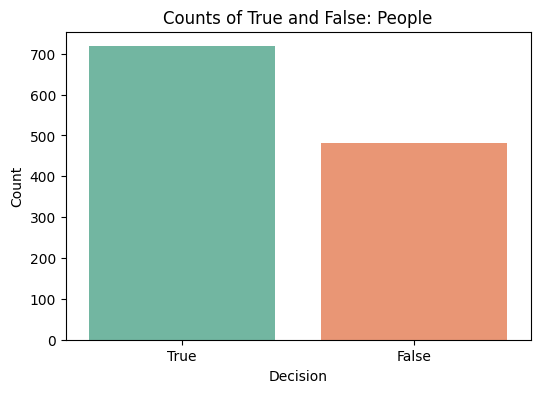

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count occurrences of True and False in the 'Majority Decision' column
decision_counts = contingency_matrix['Majority Decision'].value_counts()

# Plot bar plot for decision counts
plt.figure(figsize=(6, 4))
sns.barplot(x=decision_counts.index, y=decision_counts.values, palette='Set2')
plt.title('Counts of True and False: People')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.show()


In [19]:
# @title Import computational annotations
# @markdown Reading the GPT annotations. Enter the correct file path below

import pandas as pd
import numpy as np

annotated_file = '/content/drive/MyDrive/Klimawandel Projekt/Daten/total.csv' # @param {type:"string"}
coding_column = 'People' # @param {type:"string"}
annotated_identifier = 'Filename' # @param {type:"string"}

annotated_df = pd.read_csv(annotated_file)
# Rename the 'annotation_id' column to 'image'
#annotated_df.rename(columns={'annotation_id': 'image'}, inplace=True)

Let's look at the imported Dataframe

In [21]:
annotated_df.head()


,id,Filename,Account,body,language,Hashtag,Sentiment,Correlation_to_the_topic,Type_of_media_content,Impression_or_Sentiment,...,Education_Facts_or_News,BERTopic,platform,mean_h,mean_s,mean_v,dominant_h,dominant_s,dominant_v,max_colorname
0,climatechange_1,climatechange_1.jpg,NASA Earth,Not your typical ice cube. 🧊\n\nAlthough it is...,Language.ENGLISH,climatechange,neutral,True,Photo,Neutral,...,True,2_ice_gletscher_schnee_antarktis,instagram,0.635294,0.074510,0.650980,0.635294,0.074510,0.650980,gray
1,climatechange_2,climatechange_2.jpg,NASA,Not your typical ice cube. 🧊\n\nAlthough it is...,Language.ENGLISH,climatechange,neutral,True,Photo,Neutral,...,True,2_ice_gletscher_schnee_antarktis,instagram,0.635294,0.074510,0.650980,0.635294,0.074510,0.650980,gray
2,climatechange_3,climatechange_3.jpg,Pubity,2023 will be the hottest year recorded in hist...,Language.ENGLISH,climatechange,positive,True,Text,Negative,...,True,2_ice_gletscher_schnee_antarktis,instagram,0.064709,0.592857,0.622836,0.066667,0.858824,0.764706,orange
3,climatechange_4,climatechange_4.jpg,MEMEZAR • MEMES & MEME-CULTURE,I just know someone would try drinking them to...,Language.ENGLISH,climatechange,neutral,True,Photo,Neutral,...,True,2_ice_gletscher_schnee_antarktis,instagram,0.181906,0.118271,0.813739,0.000000,0.000000,1.000000,white
4,climatechange_5,climatechange_5.jpg,Pubity,"According to one professor, we can stop global...",Language.ENGLISH,climatechange,positive,True,Photo,Neutral,...,True,3_heat_record_temperatures_grad,instagram,0.110547,0.120437,0.466537,0.000000,0.000000,0.760784,gray


Let's create the contingency table by adding the computer annotations as a new row called 'Model' to the contingency matrix to be able to compare the Human Annotations with the Computer Annotations

In [22]:
contingency_table = pd.merge(contingency_matrix, annotated_df[[annotated_identifier, coding_column]], left_on=identifier, right_on=annotated_identifier, how='left')
contingency_table.rename(columns={coding_column: "Model"}, inplace=True)

In [23]:
contingency_table

,14,25,26,27,28,29,Majority Decision,Filename,Model
0,NaN,No,No,NaN,No,NaN,False,6631715750958599429.jpg,False
1,NaN,No,No,NaN,No,NaN,False,6675052941205835014.jpg,False
2,NaN,No,No,NaN,No,NaN,False,6684627511248162053.jpg,False
3,NaN,Yes,Yes,NaN,Yes,NaN,True,6693362974565862662.jpg,True
4,NaN,Yes,Yes,NaN,Yes,NaN,True,6696476394282552581.jpg,True
...,...,...,...,...,...,...,...,...,...
1264,NaN,NaN,NaN,NaN,NaN,Yes,True,7010472881545121029.jpg,True
1265,NaN,NaN,NaN,NaN,Yes,Yes,True,klimakrise_4.jpg,True
1266,No,NaN,NaN,NaN,No,NaN,False,klimakrise_70.jpg,False
1267,Yes,NaN,NaN,NaN,Yes,NaN,True,klimakrise_77.jpg,True


To calculate Cohen's Kappa and ML Evaluation Metrics, we need to see which unique values the columns Majority Decision and Model contain

In [24]:
import numpy as np

# Check unique values in the 'Majority Decision' column
print("Unique values in 'Majority Decision':", contingency_table['Majority Decision'].unique())

# Check unique values in the 'Model' column
print("Unique values in 'Model':", contingency_table['Model'].unique())

# Convert 'nan' values in 'Model' column to numpy.nan
contingency_table['Model'] = contingency_table['Model'].replace('nan', np.nan)

# Check unique values in the 'Model' column again after replacing 'nan' with numpy.nan
print("Unique values in 'Model' after replacing 'nan':", contingency_table['Model'].unique())



Unique values in 'Majority Decision': ['False' 'True']
Unique values in 'Model': [False True]
Unique values in 'Model' after replacing 'nan': [False True]


Let's quickly check pairwise agreement between the Model and Majority Decision using Cohen's Kappa:

In [25]:
# Only Use to get Kappa Score for Animals, Nature, People, Natural_Disasters, Artifacts, Correlation_to_the_topic

# Convert 'True' and 'False' strings to boolean values for consistency
contingency_table['Majority Decision'] = contingency_table['Majority Decision'].map({'True': True, 'False': False})
contingency_table['Model'] = contingency_table['Model'].map({True: True, False: False})

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(contingency_table['Majority Decision'], contingency_table['Model'])

# Print the kappa score
print("Cohen's kappa score:", kappa_score)



Cohen's kappa score: 0.9003397923549338


In [ ]:
# Use to calculate Kappa Score for Education_Facts_or_News,

from sklearn.metrics import cohen_kappa_score

# Convert 'nan' values in 'Model' column to numpy.nan
contingency_table['Model'] = contingency_table['Model'].replace('nan', np.nan)

# Fill NaN values in 'Model' column with a default value (e.g., False)
contingency_table['Model'].fillna(False, inplace=True)

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(contingency_table['Majority Decision'], contingency_table['Model'])

# Create a DataFrame to display the kappa score
kappa_df = pd.DataFrame({'Kappa Score': [kappa_score]})

# Print the DataFrame
print(kappa_df)


   Kappa Score
0      0.90034


In [ ]:
#USE TO CALCULATE KAPPA SCORE FOR Type_of_Media
from sklearn.metrics import cohen_kappa_score

# Drop rows with NaN values from both columns
contingency_table_cleaned = contingency_table.dropna(subset=['Majority Decision', 'Model'])

# Extract the cleaned columns
majority_decision_cleaned = contingency_table_cleaned['Majority Decision']
model_cleaned = contingency_table_cleaned['Model']

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(majority_decision_cleaned, model_cleaned)

# Print the kappa score
print("Cohen's kappa score:", kappa_score)


Cohen's kappa score: 0.9003397923549338


## Machine Learning Metrics

Finally, let's calculate Accuracy, Precision, and F1 Score and plot a confusion matrix.

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display, Markdown


# Calculating metrics
accuracy = accuracy_score(contingency_table['Majority Decision'], contingency_table['Model'])
precision = precision_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')
recall = recall_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')
f1 = f1_score(contingency_table['Majority Decision'], contingency_table['Model'], average='binary')

# Creating a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Displaying the DataFrame as a table
display(metrics_df)

,Metric,Value
0,Accuracy,0.952719
1,Precision,0.961440
2,Recall,0.961440
3,F1 Score,0.961440


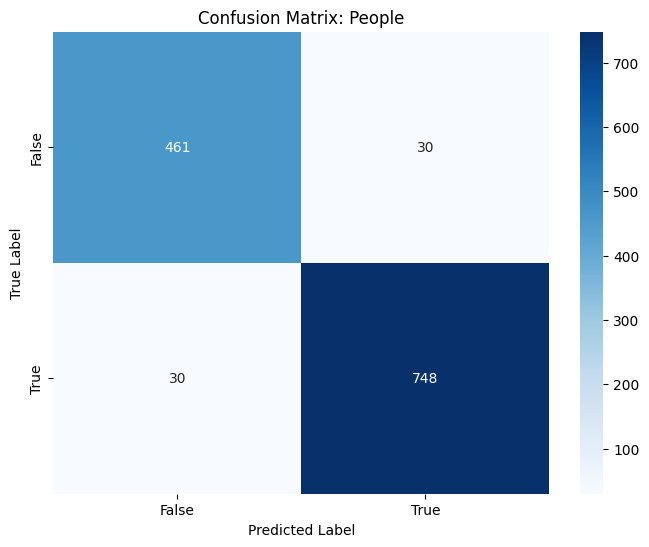

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(contingency_table['Majority Decision'], contingency_table['Model'])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix: People')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()